# Assignment #8 [ERA v2]

### Abstract
In this assignment we are going to train the CIFAR10 dataset to achieve 70% validation accuracy using less than 50,000 parameters under 20 epochs.
CIFAR10 dataset has image size of 32x32x3 and has 10 classes

### Step 1: Import the required modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

### Step 2: Preparing the Training and Testing Data

#### 2.0: View the Test and Training DataSet

Files already downloaded and verified
Files already downloaded and verified
CIFAR classes : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


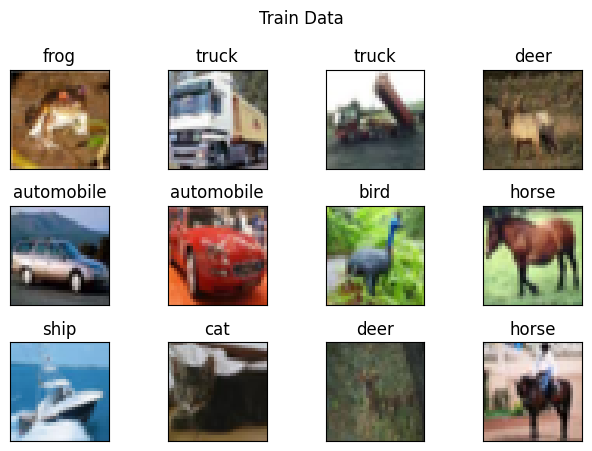

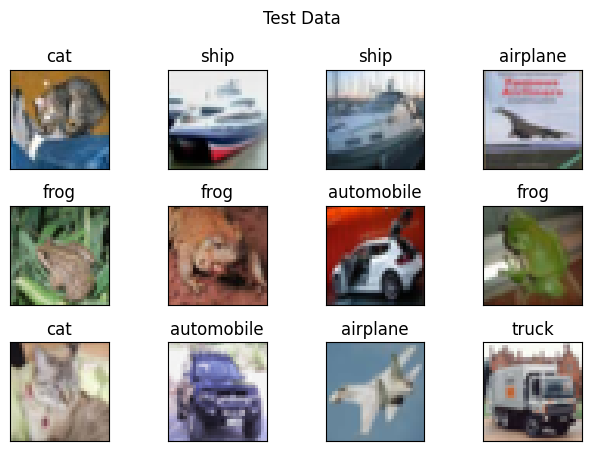

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# View the Training and Test Data
train_CIFAR = datasets.CIFAR10('./data', train=True, download=True)
test_CIFAR = datasets.CIFAR10('./data', train=False, download=True)

def showSampleImages(dataSet, title):
    fig = plt.figure()
    plt.suptitle(title)

    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.tight_layout()
        img, label = dataSet[i]
        plt.imshow(img, cmap='gray')
        plt.title(dataSet.classes[label])
        plt.xticks([])
        plt.yticks([])

print('CIFAR classes :',train_CIFAR.classes)
showSampleImages(train_CIFAR, "Train Data")
showSampleImages(test_CIFAR, "Test Data")

#### 2.1 Analyse the Dataset and find the Mean and Standard Deviation

100%|██████████| 9912422/9912422 [00:00<00:00, 95836538.38it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 101368781.44it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 23932821.62it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21285507.00it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Files already downloaded and verified
------ CIFAR10 Dataset Type and Classes ------
exp_MNIST type =>  <class 'torch.Tensor'>
exp_CIFAR type =>  <class 'numpy.ndarray'>
exp_CIFAR classes : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
------ CIFAR10 Sample Image - InTensor  ------
Files already downloaded and verified


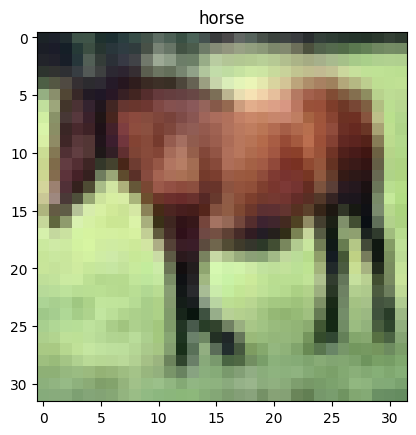

------ CIFAR10 Dataset MEAN & STD_DEV ------
Shape of CIFAR10 => torch.Size([3, 32, 32]) torch.float32
Mean of CIFAR10 =>  tensor([0.4914, 0.4822, 0.4465])
Std Dev of CIFAR10 =>  tensor([0.2470, 0.2435, 0.2616])
------ CIFAR10 Sample Image - Normalized ------


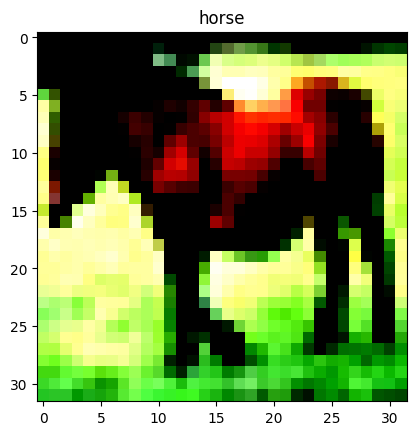

In [6]:
# Index of the sample image
idx = 7

# Download the dataset
exp_MNIST = datasets.MNIST('./data', train=True, download=True)
exp_CIFAR = datasets.CIFAR10('./data', train=True, download=True)

print('------ CIFAR10 Dataset Type and Classes ------')
print('exp_MNIST type => ',type(exp_MNIST.data))
print('exp_CIFAR type => ',type(exp_CIFAR.data))
print('exp_CIFAR classes :',exp_CIFAR.classes)

# print('------ CIFAR10 Sample Image ------')
# img, label = exp_CIFAR[idx]
# plt.imshow(img)
# plt.title(exp_CIFAR.classes[label])
# plt.show()

print('------ CIFAR10 Sample Image - InTensor  ------')
tns_CIFAR = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
img_t,label = tns_CIFAR[idx]
plt.imshow(img_t.permute(1,2,0))    # we have to use permute to change the order of the axes from C × H × W to H × W × C to match what Matplotlib expects.
plt.title(exp_CIFAR.classes[label])
plt.show()

print('------ CIFAR10 Dataset MEAN & STD_DEV ------')
imgs = torch.stack([img_t for img_t ,_ in tns_CIFAR],dim=3)
imgs.shape
print('Shape of CIFAR10 =>', img_t.shape, img_t.dtype)
print('Mean of CIFAR10 => ',imgs.view(3,-1).mean(dim=1))
print('Std Dev of CIFAR10 => ',imgs.view(3, -1).std(dim=1))

print('------ CIFAR10 Sample Image - Normalized ------')
trs_CIFAR = datasets.CIFAR10('./data', train=True, download=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))
]))
img_t,label = trs_CIFAR[idx]
plt.imshow(img_t.permute(1,2,0))    # we have to use permute to change the order of the axes from C × H × W to H × W × C to match what Matplotlib expects.
plt.title(exp_CIFAR.classes[label])
plt.show()

#### 2.2 Train and Test Phase Transformartions

In [7]:
# Train Phase Transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))  # Mean and Standard Deviation to be calculated of the pixel value
])

# Test Phase Transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))  # Mean and Standard Deviation to be calculated of the pixel value
])

#### 2.3 Download the Dataset and Splitting Train and Test Data

In [8]:
train_data = datasets.CIFAR10('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.CIFAR10('../data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:10<00:00, 15853244.52it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


#### 2.4 Dataloader Arguments & Test/Train Dataloaders

In [9]:
# Set the seed for Reproducible results
SEED = 1
set_manualSeed(SEED)

# Dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda_availabilty() else dict(shuffle=True, batch_size=64)

# Train DataLoader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# Test DataLoader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)


### Step 3: Initilizing the model

In [11]:
from torchsummary import summary
device = selectDevice()
model = Network().to(device)
summary(model, input_size=(3, 32, 32))

Using CUDA!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
         LayerNorm-2            [-1, 8, 32, 32]          16,384
              ReLU-3            [-1, 8, 32, 32]               0
           Dropout-4            [-1, 8, 32, 32]               0
            Conv2d-5           [-1, 16, 32, 32]           1,152
         LayerNorm-6           [-1, 16, 32, 32]          32,768
              ReLU-7           [-1, 16, 32, 32]               0
           Dropout-8           [-1, 16, 32, 32]               0
            Conv2d-9            [-1, 8, 32, 32]             128
        MaxPool2d-10            [-1, 8, 16, 16]               0
           Conv2d-11           [-1, 16, 16, 16]           1,152
        LayerNorm-12           [-1, 16, 16, 16]           8,192
             ReLU-13           [-1, 16, 16, 16]               0
          Dropout-14       

### Step 4: Training and Testing the model

In [12]:
from torch.optim.lr_scheduler import StepLR

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

model = Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

criterion = F.nll_loss
num_epoch = 20

for epoch in range(num_epoch):
    print('Epoch : ',epoch)
    train_acc, train_losses = train(model, device, train_loader, optimizer, criterion, train_acc, train_losses)
    test_acc, test_losses = test(model, device, test_loader, criterion, test_acc, test_losses)
    scheduler.step()

Epoch :  0


Train: Loss=1.6241 Batch_id=390 Accuracy=25.28: 100%|██████████| 391/391 [00:16<00:00, 24.35it/s]


Test set: Average loss: 1.8508, Accuracy: 2946/10000 (29.46%)

Epoch :  1


Train: Loss=1.7124 Batch_id=390 Accuracy=35.74: 100%|██████████| 391/391 [00:17<00:00, 22.76it/s]


Test set: Average loss: 1.6141, Accuracy: 4072/10000 (40.72%)

Epoch :  2


Train: Loss=1.5124 Batch_id=390 Accuracy=42.63: 100%|██████████| 391/391 [00:16<00:00, 23.69it/s]


Test set: Average loss: 1.5689, Accuracy: 4246/10000 (42.46%)

Epoch :  3


Train: Loss=1.3916 Batch_id=390 Accuracy=48.16: 100%|██████████| 391/391 [00:18<00:00, 21.60it/s]


Test set: Average loss: 1.4231, Accuracy: 4796/10000 (47.96%)

Epoch :  4


Train: Loss=1.3239 Batch_id=390 Accuracy=50.77: 100%|██████████| 391/391 [00:15<00:00, 24.93it/s]


Test set: Average loss: 1.3774, Accuracy: 4816/10000 (48.16%)

Epoch :  5


Train: Loss=1.1597 Batch_id=390 Accuracy=53.86: 100%|██████████| 391/391 [00:16<00:00, 24.12it/s]


Test set: Average loss: 1.2559, Accuracy: 5353/10000 (53.53%)

Epoch :  6


Train: Loss=1.1906 Batch_id=390 Accuracy=55.87: 100%|██████████| 391/391 [00:15<00:00, 24.47it/s]


Test set: Average loss: 1.2851, Accuracy: 5321/10000 (53.21%)

Epoch :  7


Train: Loss=1.4677 Batch_id=390 Accuracy=57.41: 100%|██████████| 391/391 [00:16<00:00, 23.82it/s]


Test set: Average loss: 1.2108, Accuracy: 5568/10000 (55.68%)

Epoch :  8


Train: Loss=1.2166 Batch_id=390 Accuracy=58.82: 100%|██████████| 391/391 [00:16<00:00, 24.41it/s]


Test set: Average loss: 1.2232, Accuracy: 5699/10000 (56.99%)

Epoch :  9


Train: Loss=1.4402 Batch_id=390 Accuracy=59.87: 100%|██████████| 391/391 [00:16<00:00, 23.61it/s]


Test set: Average loss: 1.1131, Accuracy: 5996/10000 (59.96%)

Epoch :  10


Train: Loss=0.9378 Batch_id=390 Accuracy=61.18: 100%|██████████| 391/391 [00:15<00:00, 24.59it/s]


Test set: Average loss: 1.1479, Accuracy: 5919/10000 (59.19%)

Epoch :  11


Train: Loss=1.3075 Batch_id=390 Accuracy=62.06: 100%|██████████| 391/391 [00:16<00:00, 23.20it/s]


Test set: Average loss: 1.0688, Accuracy: 6231/10000 (62.31%)

Epoch :  12


Train: Loss=1.0533 Batch_id=390 Accuracy=62.55: 100%|██████████| 391/391 [00:16<00:00, 23.51it/s]


Test set: Average loss: 0.9975, Accuracy: 6409/10000 (64.09%)

Epoch :  13


Train: Loss=1.0979 Batch_id=390 Accuracy=63.74: 100%|██████████| 391/391 [00:16<00:00, 23.45it/s]


Test set: Average loss: 1.0288, Accuracy: 6280/10000 (62.80%)

Epoch :  14


Train: Loss=1.0350 Batch_id=390 Accuracy=64.60: 100%|██████████| 391/391 [00:15<00:00, 24.87it/s]


Test set: Average loss: 1.0858, Accuracy: 6177/10000 (61.77%)

Epoch :  15


Train: Loss=0.7901 Batch_id=390 Accuracy=67.50: 100%|██████████| 391/391 [00:16<00:00, 24.36it/s]


Test set: Average loss: 0.9284, Accuracy: 6698/10000 (66.98%)

Epoch :  16


Train: Loss=0.8355 Batch_id=390 Accuracy=68.01: 100%|██████████| 391/391 [00:15<00:00, 25.27it/s]


Test set: Average loss: 0.9182, Accuracy: 6749/10000 (67.49%)

Epoch :  17


Train: Loss=0.7306 Batch_id=390 Accuracy=68.07: 100%|██████████| 391/391 [00:15<00:00, 25.15it/s]


Test set: Average loss: 0.9148, Accuracy: 6722/10000 (67.22%)

Epoch :  18


Train: Loss=0.7163 Batch_id=390 Accuracy=68.21: 100%|██████████| 391/391 [00:15<00:00, 24.48it/s]


Test set: Average loss: 0.9112, Accuracy: 6740/10000 (67.40%)

Epoch :  19


Train: Loss=0.9843 Batch_id=390 Accuracy=68.39: 100%|██████████| 391/391 [00:15<00:00, 24.59it/s]


Test set: Average loss: 0.9087, Accuracy: 6766/10000 (67.66%)



### Step 5: Analyze Training, Testing Loss and Accuracy

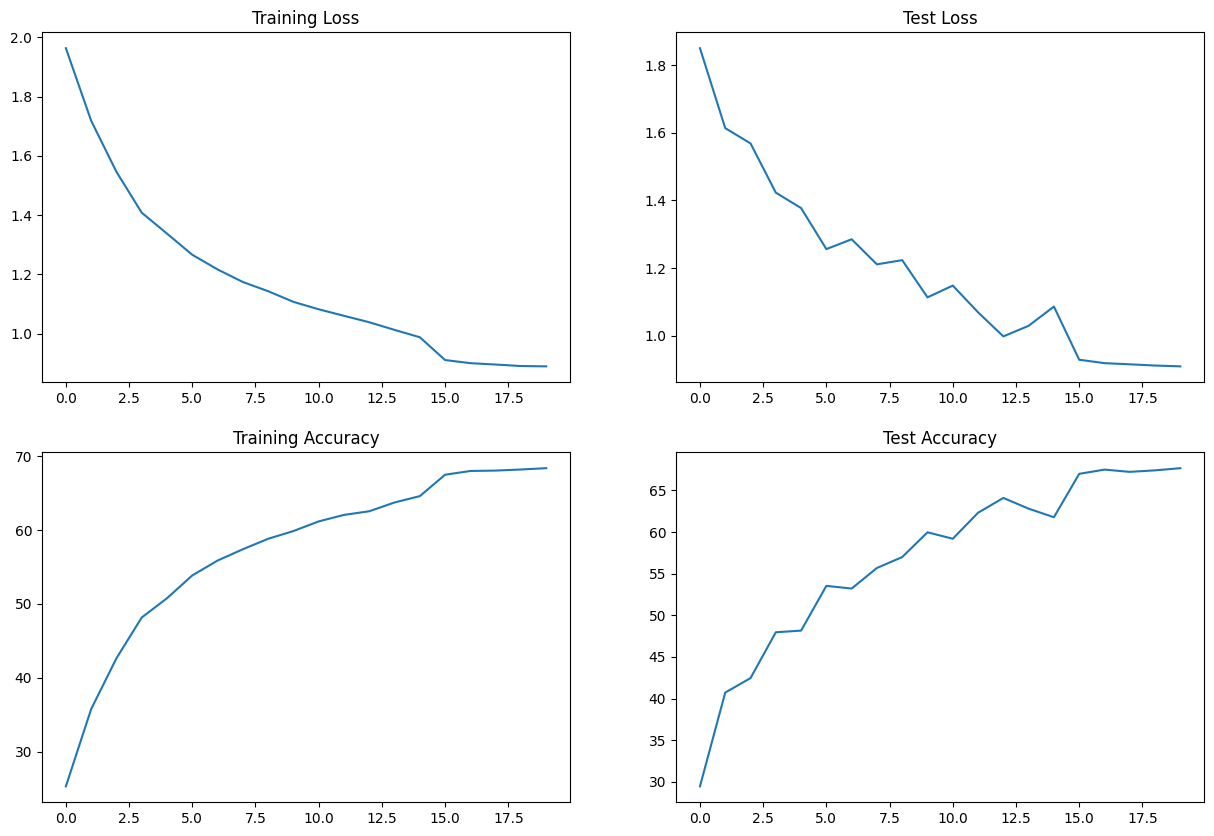

In [13]:
viewAnalysis(train_losses, train_acc, test_losses, test_acc)

### Step 6: Plot the Misclassified Images

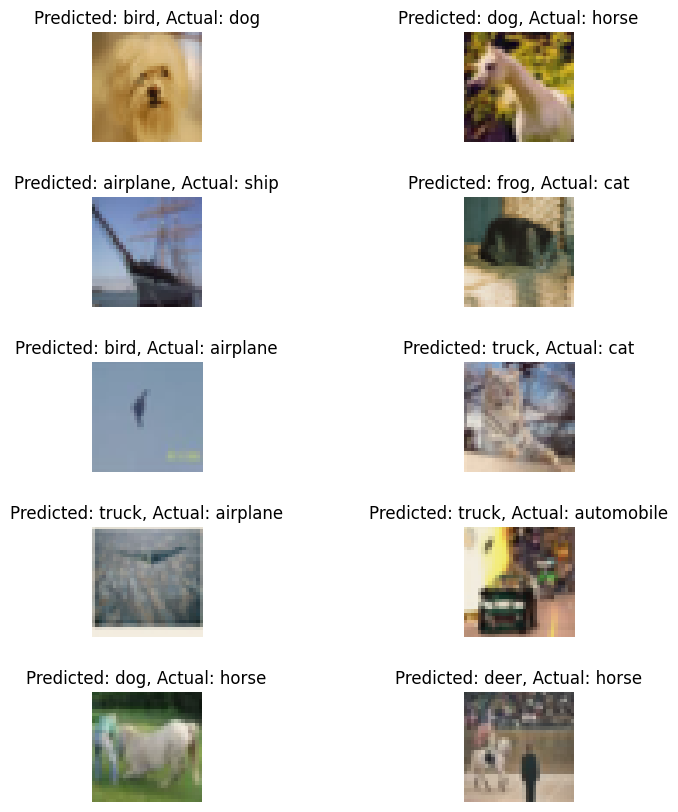

In [14]:
plotMisClassifiedImages(model, device, test_loader, test_data.classes)

# Model

### Model #2 [Layer Normalization]

In [10]:
dropout_value = 0.1

'''
    Model Architecture => C1 C2 c3 P1 C4 C5 C6 c7 P2 C8 C9 C10 GAP c11
'''
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # Convolution Block 1   [C1 + C2]
        self.convBlock1 = nn.Sequential(
            # Convolution 1                     32x32x3 -> 32x32x8 -> RF 3
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.LayerNorm([8,32,32]),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            # Convolution 2                     32x32x8 -> 32x32x16 -> RF 5
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.LayerNorm([16,32,32]),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )
        # Transition Block 1    [c3 + P1]
        self.transBlock1 = nn.Sequential(
            # convolution 3                     32x32x16 -> 32x32x8 -> RF 5
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            # MaxPooling 1                      32x32x8 -> 16x16x8 -> RF 7
            nn.MaxPool2d(2,2)
        )
        # Convolution Block 2   [C4 + C5 + C6]
        self.convBlock2 = nn.Sequential(
            # Convolution 4                     16x16x8 -> 16x16x16 -> RF 11
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.LayerNorm([16,16,16]),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            # Convolution 5                     16x16x16 -> 16x16x32 -> RF 15
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.LayerNorm([32,16,16]),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            # Convolution 6                     16x16x32 -> 16x16x32 -> RF 19
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.LayerNorm([32,16,16]),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )
        # Transition Block 2    [c7 + P2]
        self.transBlock2 = nn.Sequential(
            # convolution 7                     16x16x32 -> 16x16x8 -> RF 19
            nn.Conv2d(in_channels=32, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
            # MaxPooling 2                      16x16x8 -> 8x8x8 -> RF 23
            nn.MaxPool2d(2,2)
        )
        # Convolution Block 3   [C8 + C9 + C10]
        self.convBlock3 = nn.Sequential(
            # Convolution 8                     8x8x8 -> 8x8x16 -> RF
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.LayerNorm([16,8,8]),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            # Convolution 9                     8x8x16 -> 8x8x32 -> RF
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.LayerNorm([32,8,8]),
            nn.ReLU(),
            nn.Dropout(dropout_value),
            # Convolution 10                    8x8x32 -> 8x8x64 -> RF
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.LayerNorm([64,8,8]),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )
        # GAP Layer             [GAP]
        self.gap = nn.Sequential(
            # Global Average Pooling            8x8x64 -> 1x1x64 -> RF
            nn.AvgPool2d(kernel_size=8)
        )
        # convolution Block 4   [c11]
        self.convBlock4 = nn.Sequential(
            # Convolution 11                    1x1x64 -> 1x1x10 -> RF
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )


    def forward(self, x):
        x = self.convBlock1(x)
        x = self.transBlock1(x)
        x = self.convBlock2(x)
        x = self.transBlock2(x)
        x = self.convBlock3(x)
        x = self.gap(x)
        x = self.convBlock4(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Utility functions

### utils.py

In [2]:
""" Function to mount Google Drive to your workspace """
def mountDrive():
    from google.colab import drive
    drive.mount('/content/drive')

""" Checking if we have CUDA enabled GPU or not, """
def cuda_availabilty():
    return torch.cuda.is_available()

""" Function to set manual seed for reproducible results """
def set_manualSeed(seed):
    # Sets the seed for PyTorch's Random Number Generator
    torch.manual_seed(seed)
    if cuda_availabilty():
        torch.cuda.manual_seed(seed)

""" Function to select Device """
def selectDevice():
    using_cuda = cuda_availabilty()
    print("Using CUDA!" if using_cuda else "Not using CUDA.")
    # if so select "cuda" as device for processing else "cpu"
    device = torch.device("cuda" if using_cuda else "cpu")
    return device

""" Function to download the MNIST dataset """
def download_MNIST(train, transform):
    from torchvision import datasets
    return datasets.MNIST('../data', train=train, download=True, transform=transform)

""" Function to download the CIFAR10 dataset """
def download_CIFAR10(train, transform):
    from torchvision import datasets
    return datasets.CIFAR10('../data', train=train, download=True, transform=transform)

""" Function to view the statistics around our data """
def stats_dataset(data):
    train_data = data.train_data
    train_data = data.transform(train_data.numpy())

    print('[Train]')
    print(' - Numpy Shape:', data.train_data.cpu().numpy().shape)
    print(' - Tensor Shape:', data.train_data.size())
    print(' - min:', torch.min(train_data))     # Min Pixel Value
    print(' - max:', torch.max(train_data))     # Max Pixel Value
    print(' - mean:', torch.mean(train_data))
    print(' - std:', torch.std(train_data))
    print(' - var:', torch.var(train_data))

"""Funciton to view the samples in dataset """
def view_dataset(data_loader, title):
    import matplotlib.pyplot as plt

    batch_data, batch_label = next(iter(data_loader))

    fig = plt.figure()
    plt.suptitle(title)

    for i in range(12):
      plt.subplot(3,4,i+1)
      plt.tight_layout()
      plt.imshow(batch_data[i].squeeze(0).permute(1,2,0), cmap='gray')
      plt.title(batch_label[i].item())
      plt.xticks([])
      plt.yticks([])

""" Function to Get Correct Prediction Count """
def GetCorrectPredCount(pPrediction, pLabels ):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

""" Function to view the Training and Testing Accuracy and Loss """
def viewAnalysis(train_losses, train_acc, test_losses, test_acc):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")

""" Function to plot the misClassified Images """
def plotMisClassifiedImages(model, device, test_loader,classes):
    classes = test_data.classes
    model.eval()
    misClassifiedImages = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            idxs_mask = ~pred.eq(target.view_as(pred)).view(-1)
            misClassifiedImages.extend([(data[i], pred[i], target[i]) for i in range(len(idxs_mask)) if idxs_mask[i]])
            if len(misClassifiedImages) >= 10:
                break

    misClassifiedImages = misClassifiedImages[:10]

    fig, axes = plt.subplots(5, 2, figsize=(8, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, (img, pred, target) in enumerate(misClassifiedImages):
        img, pred, target = img.cpu().numpy(), pred.cpu(), target.cpu()
        ax = axes[i//2, i%2]
        img = img.transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        img = img * std + mean  # De-normalize
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f'Predicted: {classes[pred.item()]}, Actual: {classes[target.item()]}')
        ax.axis('off')

    plt.show()

In [3]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, criterion, train_acc, train_losses):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # Get a batch of samples
        data, target = data.to(device) , target.to(device)
        # Initilizes the gradients to zero
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate Loss
        loss = criterion(pred, target)
        train_loss+=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))
    return train_acc, train_losses

def test(model, device, test_loader, criterion, test_acc, test_losses):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)

            test_loss += criterion(output, target, reduction='sum').item()  # Sum up batch loss
            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_acc, test_losses